In [16]:
import tesserocr
from PIL import Image
import numpy as np

image = Image.open('captcha2.png')
image = image.convert('L')
threshold  = 100
array = np.array(image)
array = np.where(array > threshold ,255, 0)

image = Image.fromarray(array.astype('uint8'))
image.show()
print(tesserocr.image_to_text(image))

a b 3 c



In [1]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from io import BytesIO
import numpy as np
from PIL import Image
import tesserocr
import re
import time

from retrying import retry
from selenium.webdriver.support.wait import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException

LOGIN_URL = 'https://captcha7.scrape.center/'
ACCOUTN = 'admin'
PASSWORD = 'admin'
THRESHOLD = 150

def preprocess(image):
    image = image.convert('L')
    array = np.array(image)
    array = np.where(array > THRESHOLD, 255, 0)
    image = Image.fromarray(array.astype('uint8'))
    return image

@retry(stop_max_attempt_number=10, retry_on_result=lambda x:x is False)
def login():
    # browser = webdriver.Chrome()
    browser.get(LOGIN_URL)

    ### 这里应该加一个等待
    # 填入账号和密码
    browser.find_element(By.CSS_SELECTOR, '.username input[type="text"]').send_keys(ACCOUTN)
    time.sleep(1)
    browser.find_element(By.CSS_SELECTOR, '.password input[type="password"]').send_keys(PASSWORD)
    time.sleep(1)

    # 验证码图片识别
    captcha = browser.find_element(By.CSS_SELECTOR, '#captcha')
    image = Image.open(BytesIO(captcha.screenshot_as_png))
    print(type(captcha.screenshot_as_png))
    image = preprocess(image)
    captcha = tesserocr.image_to_text(image)
    captcha = re.sub('[^A-Za-z0-9]', '', captcha)

    # 填入验证码
    browser.find_element(By.CSS_SELECTOR, '.captcha input').send_keys(captcha)
    time.sleep(1)

    # 点击登录按钮
    # browser.find_element(By.CSS_SELECTOR, 'button[type="button"]').click()
    browser.find_element(By.CSS_SELECTOR, '.login').click()

    # 判断是否登录成功
    try:
        WebDriverWait(browser, 5).until(EC.presence_of_element_located((By.XPATH, '//h2[contains(., "登录成功")]')))
        time.sleep(5)
        browser.close()
        return True
    except TimeoutException:
        return False

if __name__ == "__main__":
    browser = webdriver.Chrome()
    login()

<class 'bytes'>


# 果核剥壳

草稿

```Python
captcha = browser.find_element(By.CSS_SELECTOR, '#captcha')
image = Image.open(BytesIO(captcha.screenshot_as_png))
image = preprocess(image)
captcha = tesserocr.image_to_text(image)
captcha = re.sub('[^A-Za-z0-9]', '', captcha)
```

### 通过 获取网页源代码中验证码图片的 `src` 链接获取图片

In [27]:
import numpy as np
import requests
from PIL import Image
import time
from selenium import webdriver
from selenium.webdriver.common.by import By

browser = webdriver.Chrome()

browser.get('https://www.ghxi.com/login')

browser.find_element(By.CSS_SELECTOR, '.captcha-button').click()
time.sleep(2)
browser.switch_to.frame('tcaptcha_iframe')
image_src = browser.find_element(By.CSS_SELECTOR, '#slideBg').get_attribute('src')
image_src

'https://t.captcha.qq.com/hycdn?index=1&image=937404024411908608?aid=2058282041&sess=s0hG3NNN8naKED4Nzdh_qowMORXiQvJ7fQGW5JgovCtpsca8zFvmCDV7Dbm7aegwCWsm6RltEwwk61IT5SpJBUEuuCq01yf4WXTm4E4gkskPbIpWzoEkuWVKIs-4P3rD7QOb5FoyUFm5kYlpsorPiHRmE-Fq2-2VpCR1GGj9tXe_IQsZZwTQG3x5OSIUK6Fz1z6obFbCKWnfSG0b8zj5qDYkDo-ajFX3j_mIOIcMbhVrD0UWSoWl8zeazz_9Nud6gvbtsy1NshTEIOcoYfkkrG8AipEnFMlTgM5PMtoPttfjg*&sid=6957669013621477376&img_index=1&subsid=3'

(680, 390)


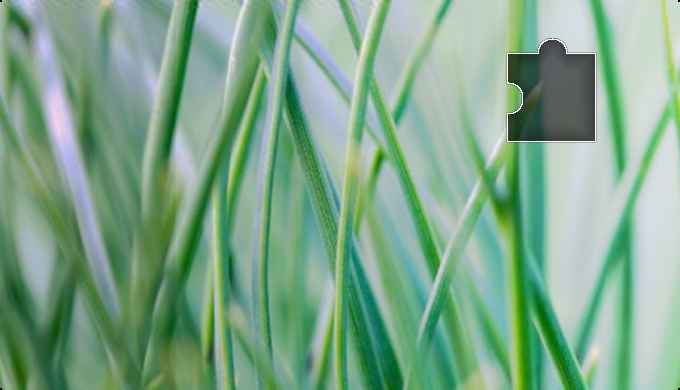

In [30]:
image = requests.get(image_src).content
image = Image.open(BytesIO(image))
print(np.size(image))
image

### 通过 **`selenium`** 的截图功能获取图片

In [43]:
import numpy as np
import requests
from PIL import Image
import time
from selenium import webdriver
from selenium.webdriver.common.by import By

browser = webdriver.Chrome()

browser.get('https://www.ghxi.com/login')

browser.find_element(By.CSS_SELECTOR, '.captcha-button').click()
time.sleep(2)
browser.switch_to.frame('tcaptcha_iframe')

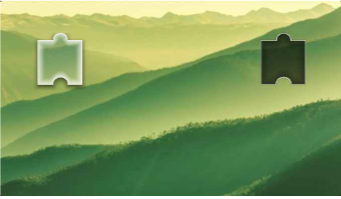

In [44]:
slideBgWrap = browser.find_element(By.CSS_SELECTOR, '#slideBgWrap')
slideBgWrap = Image.open(BytesIO(slideBgWrap.screenshot_as_png))
slideBgWrap

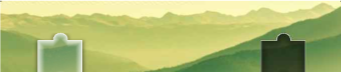

In [45]:
slideBlockWrap = browser.find_element(By.CSS_SELECTOR, '#slideBlockWrap')
slideBlockWrap = Image.open(BytesIO(slideBlockWrap.screenshot_as_png))
slideBlockWrap

## 图片处理

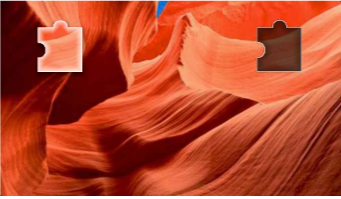

In [40]:
image

In [47]:
import cv2

GAUSSIAN_BLUR_KERNEL_SIZE = (5, 5)
GAUSSIAN_BLUR_SIGMA_X = 0
CANNY_THRESHOLD1 = 200
CANNY_THRESHOLD2 = 450


def get_gaussian_blur_image(image):
    return cv2.GaussianBlur(image, GAUSSIAN_BLUR_KERNEL_SIZE, GAUSSIAN_BLUR_SIGMA_X)


def get_canny_image(image):
    return cv2.Canny(image, CANNY_THRESHOLD1, CANNY_THRESHOLD2)


def get_contours(image):
    contours, _ = cv2.findContours(image, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
    return contours


def get_contour_area_threshold(image_width, image_height):
    contour_area_min = (image_width * 0.15) * (image_height * 0.25) * 0.8
    contour_area_max = (image_width * 0.15) * (image_height * 0.25) * 1.2
    return contour_area_min, contour_area_max


def get_arc_length_threshold(image_width, image_height):
    arc_length_min = ((image_width * 0.15) + (image_height * 0.25)) * 2 * 0.8
    arc_length_max = ((image_width * 0.15) + (image_height * 0.25)) * 2 * 1.2
    return arc_length_min, arc_length_max


def get_offset_threshold(image_width):
    offset_min = 0.2 * image_width
    offset_max = 0.85 * image_width
    return offset_min, offset_max


def main():
    image_raw = cv2.imread('captcha3.png')
    image_height, image_width, _ = image_raw.shape
    image_gaussian_blur = get_gaussian_blur_image(image_raw)
    image_canny = get_canny_image(image_gaussian_blur)
    contours = get_contours(image_canny)
    cv2.imwrite('image_canny.png', image_canny)
    cv2.imwrite('image_gaussian_blur.png', image_gaussian_blur)
    contour_area_min, contour_area_max = get_contour_area_threshold(image_width, image_height)
    arc_length_min, arc_length_max = get_arc_length_threshold(image_width, image_height)
    offset_min, offset_max = get_offset_threshold(image_width)
    offset = None
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        if contour_area_min < cv2.contourArea(contour) < contour_area_max and \
                arc_length_min < cv2.arcLength(contour, True) < arc_length_max and \
                offset_min < x < offset_max:
            cv2.rectangle(image_raw, (x, y), (x + w, y + h), (0, 0, 255), 2)
            offset = x
    cv2.imwrite('image_label.png', image_raw)
    print('offset', offset)

if __name__ == '__main__':
    main()


offset 163
